## 1. 환경 설정 및 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

# RDKit 시각화 설정
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.2.2+cu118
NumPy version: 1.26.4


## 2. 예제 분자 준비

간단한 분자(에탄올, C2H6O)를 사용하여 GCN의 작동을 이해합니다.

분자: CCO
원자 개수: 3
결합 개수: 2



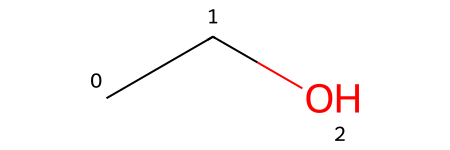

In [2]:
# 에탄올 분자 생성
smiles = 'CCO'  # 에탄올
mol = Chem.MolFromSmiles(smiles)

print(f"분자: {smiles}")
print(f"원자 개수: {mol.GetNumAtoms()}")
print(f"결합 개수: {mol.GetNumBonds()}")
print()

# 분자 구조 시각화
mol

## 3. 분자를 그래프 데이터로 변환

이전 튜토리얼에서 배운 내용을 활용하여 분자를 그래프로 변환합니다.

In [3]:
def get_atom_features(atom):
    """원자의 특성을 벡터로 변환 (간단한 버전)"""
    # Atomic number (원자 번호를 one-hot encoding)
    atom_types = [6, 7, 8, 9]  # C, N, O, F
    atomic_num = atom.GetAtomicNum()
    atom_type_encoding = [1 if atomic_num == t else 0 for t in atom_types]
    
    # Degree (연결된 원자 수)
    degree = atom.GetDegree()
    
    # Hydrogen count
    num_hs = atom.GetTotalNumHs()
    
    return atom_type_encoding + [degree, num_hs]


def mol_to_graph(mol):
    """분자를 그래프로 변환"""
    # 노드 특성 행렬 (Node feature matrix)
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append(get_atom_features(atom))
    X = torch.tensor(node_features, dtype=torch.float)
    
    # 인접 행렬 (Adjacency matrix)
    num_atoms = mol.GetNumAtoms()
    adj_matrix = np.zeros((num_atoms, num_atoms))
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1
    
    # Self-loop 추가 (자기 자신과의 연결)
    adj_matrix = adj_matrix + np.eye(num_atoms)
    A = torch.tensor(adj_matrix, dtype=torch.float)
    
    return X, A


# 그래프 데이터 생성
X, A = mol_to_graph(mol)

print("노드 특성 행렬 (Node Feature Matrix) X:")
print(f"Shape: {X.shape}  (원자 수 x 특성 차원)")
print(X)
print()

print("인접 행렬 (Adjacency Matrix) A:")
print(f"Shape: {A.shape}")
print(A)

노드 특성 행렬 (Node Feature Matrix) X:
Shape: torch.Size([3, 6])  (원자 수 x 특성 차원)
tensor([[1., 0., 0., 0., 1., 3.],
        [1., 0., 0., 0., 2., 2.],
        [0., 0., 1., 0., 1., 1.]])

인접 행렬 (Adjacency Matrix) A:
Shape: torch.Size([3, 3])
tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])


In [4]:
# 원자별 특성 확인
atom_info = []
for i, atom in enumerate(mol.GetAtoms()):
    atom_info.append({
        'Index': i,
        'Symbol': atom.GetSymbol(),
        'Atomic Num': atom.GetAtomicNum(),
        'Degree': atom.GetDegree(),
        'Num Hs': atom.GetTotalNumHs()
    })

df_atoms = pd.DataFrame(atom_info)
print("\n원자 정보:")
print(df_atoms)


원자 정보:
   Index Symbol  Atomic Num  Degree  Num Hs
0      0      C           6       1       3
1      1      C           6       2       2
2      2      O           8       1       1


## 4. GCN의 수학적 정의

Graph Convolutional Network (GCN)의 핵심 연산은 다음과 같습니다:

$$
H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)})
$$

여기서:
- $H^{(l)}$: $l$번째 layer의 노드 임베딩 행렬
- $\tilde{A} = A + I$: Self-loop가 추가된 인접 행렬
- $\tilde{D}$: $\tilde{A}$의 degree matrix (대각 행렬)
- $W^{(l)}$: 학습 가능한 가중치 행렬
- $\sigma$: 활성화 함수 (ReLU 등)

### 단계별 분해:

1. **Self-loop 추가**: $\tilde{A} = A + I$ (이미 완료)
2. **Degree matrix 계산**: $\tilde{D}_{ii} = \sum_j \tilde{A}_{ij}$
3. **정규화**: $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$ (대칭 정규화)
4. **Feature 변환**: 가중치 행렬 $W$와 곱셈
5. **활성화 함수 적용**: ReLU 등

## 5. GCN Layer 직접 구현

수학적 정의를 코드로 구현합니다.

In [5]:
class SimpleGCNLayer(nn.Module):
    """간단한 GCN Layer 구현"""
    
    def __init__(self, in_features, out_features):
        super(SimpleGCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 학습 가능한 가중치 행렬 W
        self.W = nn.Linear(in_features, out_features, bias=False)
        
    def forward(self, X, A):
        """
        Args:
            X: 노드 특성 행렬 [num_nodes, in_features]
            A: 인접 행렬 [num_nodes, num_nodes] (self-loop 포함)
        
        Returns:
            H: 변환된 노드 임베딩 [num_nodes, out_features]
        """
        # Step 1: Degree matrix 계산
        D = torch.diag(A.sum(dim=1))  # [num_nodes, num_nodes]
        
        # Step 2: D^{-1/2} 계산
        D_inv_sqrt = torch.diag(1.0 / torch.sqrt(D.diag() + 1e-6))
        
        # Step 3: 정규화된 인접 행렬 계산: D^{-1/2} A D^{-1/2}
        A_normalized = D_inv_sqrt @ A @ D_inv_sqrt
        
        # Step 4: Feature 변환: H = A_normalized @ X @ W
        H = A_normalized @ X
        H = self.W(H)
        
        return H


print("✓ SimpleGCNLayer 클래스 정의 완료")

✓ SimpleGCNLayer 클래스 정의 완료


## 6. GCN Layer 작동 단계별 분석

각 단계에서 데이터가 어떻게 변환되는지 자세히 살펴봅니다.

In [6]:
# Step 1: Degree matrix 계산
D = torch.diag(A.sum(dim=1))
print("Degree Matrix D:")
print(D)
print(f"\n각 노드의 degree (자기 자신 포함):")
print(A.sum(dim=1))

Degree Matrix D:
tensor([[2., 0., 0.],
        [0., 3., 0.],
        [0., 0., 2.]])

각 노드의 degree (자기 자신 포함):
tensor([2., 3., 2.])


In [7]:
# Step 2: D^{-1/2} 계산
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(D.diag()))
print("D^{-1/2}:")
print(D_inv_sqrt)

D^{-1/2}:
tensor([[0.7071, 0.0000, 0.0000],
        [0.0000, 0.5774, 0.0000],
        [0.0000, 0.0000, 0.7071]])


정규화된 인접 행렬 (Normalized Adjacency Matrix):
tensor([[0.5000, 0.4082, 0.0000],
        [0.4082, 0.3333, 0.4082],
        [0.0000, 0.4082, 0.5000]])


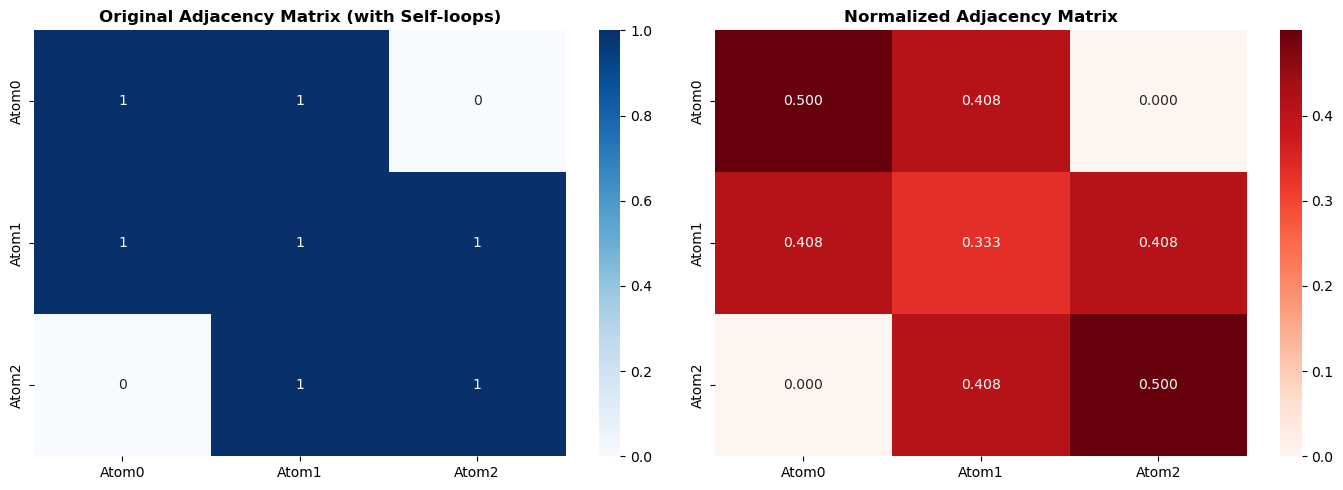

In [8]:
# Step 3: 정규화된 인접 행렬
A_normalized = D_inv_sqrt @ A @ D_inv_sqrt
print("정규화된 인접 행렬 (Normalized Adjacency Matrix):")
print(A_normalized)

# 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(A.numpy(), annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=[f'Atom{i}' for i in range(A.shape[0])],
            yticklabels=[f'Atom{i}' for i in range(A.shape[0])])
plt.title('Original Adjacency Matrix (with Self-loops)', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
sns.heatmap(A_normalized.numpy(), annot=True, fmt='.3f', cmap='Reds', cbar=True,
            xticklabels=[f'Atom{i}' for i in range(A.shape[0])],
            yticklabels=[f'Atom{i}' for i in range(A.shape[0])])
plt.title('Normalized Adjacency Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 정규화의 의미

- **원본 인접 행렬**: 연결된 이웃의 정보를 단순 합산
- **정규화된 인접 행렬**: 각 노드의 degree에 따라 가중 평균을 계산
  - Degree가 큰 노드의 영향을 줄임 (overpowering 방지)
  - 모든 노드가 공평하게 정보를 전달받도록 함

## 7. GCN Layer 적용 실습

실제로 GCN layer를 통과시켜 노드 임베딩이 어떻게 변하는지 확인합니다.

In [9]:
# GCN layer 생성
in_features = X.shape[1]  # 6 (원자 특성 차원)
out_features = 8  # 출력 차원을 8로 설정

gcn_layer = SimpleGCNLayer(in_features, out_features)

print(f"입력 차원: {in_features}")
print(f"출력 차원: {out_features}")
print(f"\nGCN Layer 가중치 W shape: {gcn_layer.W.weight.shape}")

입력 차원: 6
출력 차원: 8

GCN Layer 가중치 W shape: torch.Size([8, 6])


In [10]:
# GCN layer 통과
H = gcn_layer(X, A)

print("입력 노드 특성 X:")
print(f"Shape: {X.shape}")
print(X)
print()

print("출력 노드 임베딩 H:")
print(f"Shape: {H.shape}")
print(H)

입력 노드 특성 X:
Shape: torch.Size([3, 6])
tensor([[1., 0., 0., 0., 1., 3.],
        [1., 0., 0., 0., 2., 2.],
        [0., 0., 1., 0., 1., 1.]])

출력 노드 임베딩 H:
Shape: torch.Size([3, 8])
tensor([[-0.7236, -0.9827,  0.3752, -0.5085, -0.4557, -0.1403,  0.4249,  0.5093],
        [-0.7063, -0.8486,  0.6124, -0.4965, -0.5472, -0.0129,  0.2597,  0.6740],
        [-0.4945, -0.4049,  0.5580, -0.1883, -0.3138,  0.2013, -0.0246,  0.6329]],
       grad_fn=<MmBackward0>)


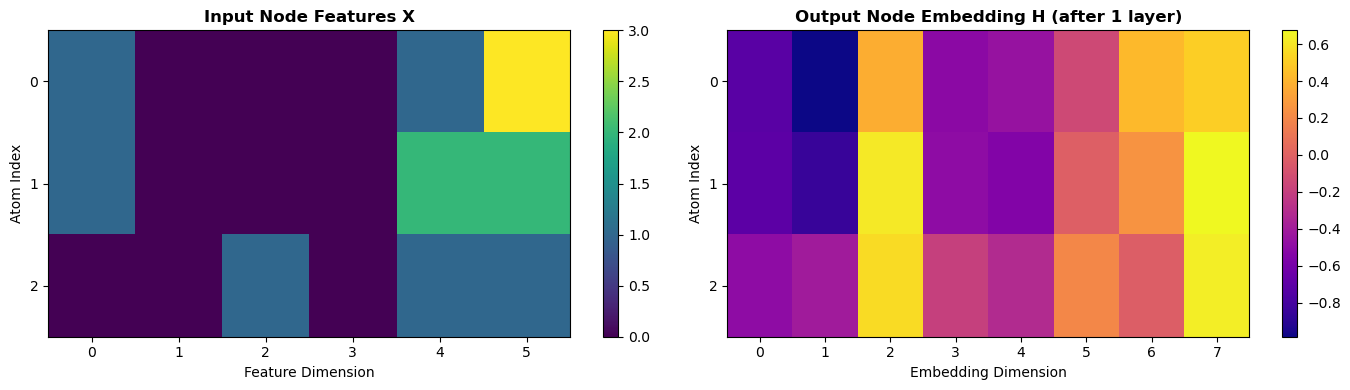

In [11]:
# 임베딩 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 입력 특성
im1 = axes[0].imshow(X.detach().numpy(), cmap='viridis', aspect='auto')
axes[0].set_title('Input Node Features X', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature Dimension')
axes[0].set_ylabel('Atom Index')
axes[0].set_yticks(range(X.shape[0]))
plt.colorbar(im1, ax=axes[0])

# 출력 임베딩
im2 = axes[1].imshow(H.detach().numpy(), cmap='plasma', aspect='auto')
axes[1].set_title('Output Node Embedding H (after 1 layer)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Atom Index')
axes[1].set_yticks(range(H.shape[0]))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

## 8. 다층 GCN 구현

여러 개의 GCN layer를 쌓아서 더 깊은 정보를 학습합니다.

In [12]:
class MultiLayerGCN(nn.Module):
    """다층 GCN 모델"""
    
    def __init__(self, in_features, hidden_features, out_features, num_layers=3):
        super(MultiLayerGCN, self).__init__()
        self.num_layers = num_layers
        
        # Layer 리스트 생성
        self.layers = nn.ModuleList()
        
        # 첫 번째 layer
        self.layers.append(SimpleGCNLayer(in_features, hidden_features))
        
        # 중간 layers
        for _ in range(num_layers - 2):
            self.layers.append(SimpleGCNLayer(hidden_features, hidden_features))
        
        # 마지막 layer
        self.layers.append(SimpleGCNLayer(hidden_features, out_features))
    
    def forward(self, X, A):
        """
        Returns:
            H_list: 각 layer의 출력 리스트 (시각화용)
            H: 최종 출력
        """
        H = X
        H_list = [H]
        
        for i, layer in enumerate(self.layers):
            H = layer(H, A)
            # 마지막 layer가 아니면 ReLU 적용
            if i < len(self.layers) - 1:
                H = F.relu(H)
            H_list.append(H)
        
        return H_list, H


# 3-layer GCN 생성
model = MultiLayerGCN(
    in_features=X.shape[1],  # 6
    hidden_features=16,
    out_features=8,
    num_layers=3
)

print("Multi-Layer GCN 구조:")
print(model)
print(f"\n총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

Multi-Layer GCN 구조:
MultiLayerGCN(
  (layers): ModuleList(
    (0): SimpleGCNLayer(
      (W): Linear(in_features=6, out_features=16, bias=False)
    )
    (1): SimpleGCNLayer(
      (W): Linear(in_features=16, out_features=16, bias=False)
    )
    (2): SimpleGCNLayer(
      (W): Linear(in_features=16, out_features=8, bias=False)
    )
  )
)

총 파라미터 수: 480


In [13]:
# 다층 GCN 실행
H_list, H_final = model(X, A)

print("각 layer의 출력 shape:")
for i, H in enumerate(H_list):
    if i == 0:
        print(f"  Input: {H.shape}")
    else:
        print(f"  Layer {i}: {H.shape}")

각 layer의 출력 shape:
  Input: torch.Size([3, 6])
  Layer 1: torch.Size([3, 16])
  Layer 2: torch.Size([3, 16])
  Layer 3: torch.Size([3, 8])


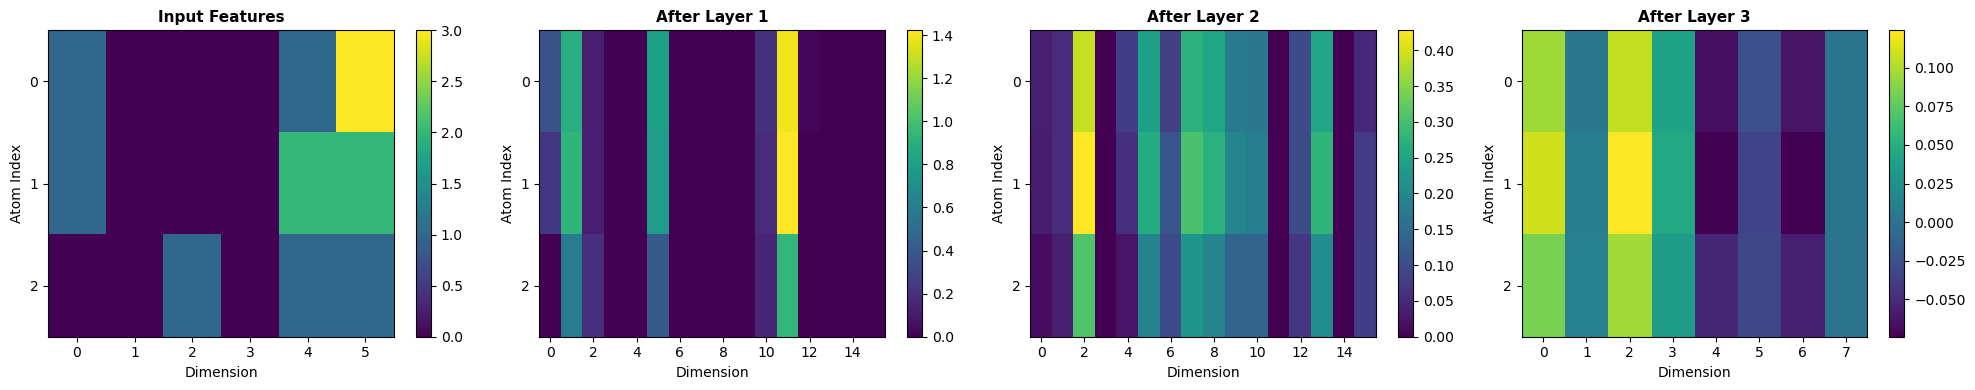


💡 관찰 포인트:
  - 각 layer를 거칠수록 임베딩이 어떻게 변하는지 확인
  - 이웃 정보가 점진적으로 통합되는 과정
  - 유사한 원자들의 임베딩이 비슷해지는 경향


In [14]:
# 각 layer별 임베딩 시각화
fig, axes = plt.subplots(1, len(H_list), figsize=(5 * len(H_list), 4))

for i, H in enumerate(H_list):
    im = axes[i].imshow(H.detach().numpy(), cmap='viridis', aspect='auto')
    if i == 0:
        axes[i].set_title('Input Features', fontsize=11, fontweight='bold')
    else:
        axes[i].set_title(f'After Layer {i}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Dimension')
    axes[i].set_ylabel('Atom Index')
    axes[i].set_yticks(range(H.shape[0]))
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

print("\n💡 관찰 포인트:")
print("  - 각 layer를 거칠수록 임베딩이 어떻게 변하는지 확인")
print("  - 이웃 정보가 점진적으로 통합되는 과정")
print("  - 유사한 원자들의 임베딩이 비슷해지는 경향")

## 9. Graph Pooling: 분자 전체 표현 생성

노드 임베딩을 하나의 그래프 수준 벡터로 집계합니다.

In [15]:
# 여러 pooling 방법 비교
pooling_methods = {
    'Mean Pooling': H_final.mean(dim=0),
    'Max Pooling': H_final.max(dim=0)[0],
    'Sum Pooling': H_final.sum(dim=0)
}

print("Graph-level 표현 (분자 전체 벡터):")
print()

for method, graph_embedding in pooling_methods.items():
    print(f"{method}:")
    print(f"  Shape: {graph_embedding.shape}")
    print(f"  Values: {graph_embedding}")
    print()

Graph-level 표현 (분자 전체 벡터):

Mean Pooling:
  Shape: torch.Size([8])
  Values: tensor([ 0.0965,  0.0097,  0.1089,  0.0408, -0.0641, -0.0303, -0.0652,  0.0028],
       grad_fn=<MeanBackward1>)

Max Pooling:
  Shape: torch.Size([8])
  Values: tensor([ 0.1098,  0.0123,  0.1242,  0.0464, -0.0531, -0.0258, -0.0578,  0.0033],
       grad_fn=<MaxBackward0>)

Sum Pooling:
  Shape: torch.Size([8])
  Values: tensor([ 0.2894,  0.0291,  0.3266,  0.1223, -0.1923, -0.0908, -0.1957,  0.0084],
       grad_fn=<SumBackward1>)



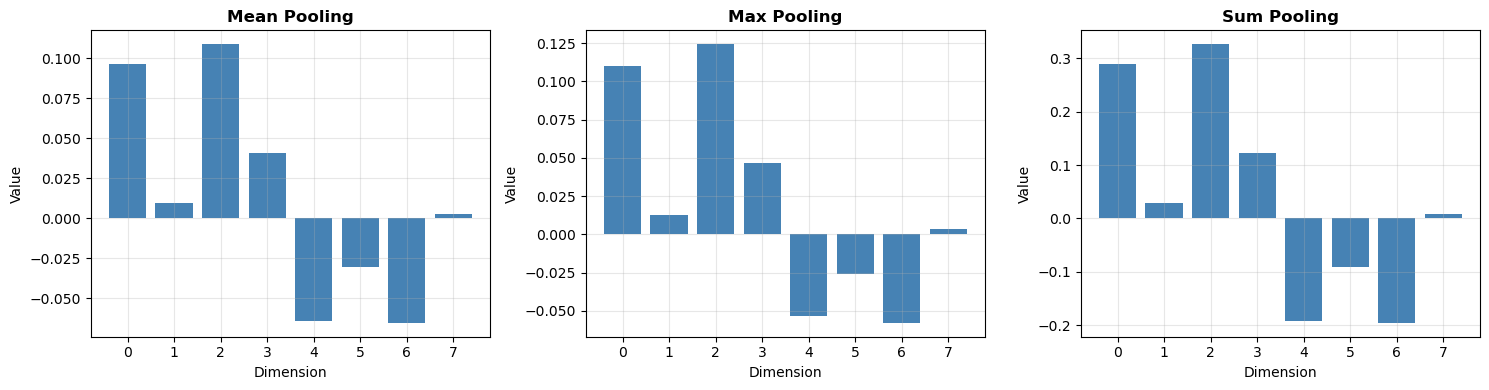


💡 Pooling 방법의 차이:
  - Mean: 모든 원자의 평균 정보 (가장 일반적)
  - Max: 가장 두드러진 특성을 포착
  - Sum: 분자 크기에 민감 (큰 분자는 큰 값)


In [16]:
# Pooling 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (method, graph_emb) in enumerate(pooling_methods.items()):
    emb_list = graph_emb.detach().numpy().tolist()
    axes[idx].bar(range(len(emb_list)), emb_list, color='steelblue')
    axes[idx].set_title(method, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Dimension')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Pooling 방법의 차이:")
print("  - Mean: 모든 원자의 평균 정보 (가장 일반적)")
print("  - Max: 가장 두드러진 특성을 포착")
print("  - Sum: 분자 크기에 민감 (큰 분자는 큰 값)")

## 10. 완전한 GCN 모델: 회귀/분류 예측

Graph pooling 후 MLP를 추가하여 최종 예측을 수행합니다.

In [17]:
class GCNForPrediction(nn.Module):
    """예측을 위한 완전한 GCN 모델"""
    
    def __init__(self, in_features, hidden_features, num_layers=3, 
                 pool_method='mean', num_classes=1):
        super(GCNForPrediction, self).__init__()
        self.pool_method = pool_method
        
        # GCN layers
        self.gcn = MultiLayerGCN(in_features, hidden_features, hidden_features, num_layers)
        
        # Prediction head (MLP)
        self.pred_head = nn.Sequential(
            nn.Linear(hidden_features, hidden_features // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_features // 2, num_classes)
        )
    
    def forward(self, X, A):
        # GCN layers
        _, H = self.gcn(X, A)
        
        # Graph pooling
        if self.pool_method == 'mean':
            graph_emb = H.mean(dim=0)
        elif self.pool_method == 'max':
            graph_emb = H.max(dim=0)[0]
        elif self.pool_method == 'sum':
            graph_emb = H.sum(dim=0)
        
        # Prediction
        out = self.pred_head(graph_emb)
        
        return out, graph_emb


# 회귀 예측 모델 생성 (예: 용해도 예측)
pred_model = GCNForPrediction(
    in_features=X.shape[1],
    hidden_features=16,
    num_layers=3,
    pool_method='mean',
    num_classes=1  # 회귀 문제
)

print("GCN Prediction 모델:")
print(pred_model)
print(f"\n총 파라미터 수: {sum(p.numel() for p in pred_model.parameters()):,}")

GCN Prediction 모델:
GCNForPrediction(
  (gcn): MultiLayerGCN(
    (layers): ModuleList(
      (0): SimpleGCNLayer(
        (W): Linear(in_features=6, out_features=16, bias=False)
      )
      (1-2): 2 x SimpleGCNLayer(
        (W): Linear(in_features=16, out_features=16, bias=False)
      )
    )
  )
  (pred_head): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=8, out_features=1, bias=True)
  )
)

총 파라미터 수: 753


In [18]:
# 예측 수행 (학습되지 않은 상태)
prediction, graph_embedding = pred_model(X, A)

print("예측 결과:")
print(f"  Graph Embedding shape: {graph_embedding.shape}")
print(f"  Graph Embedding: {graph_embedding}")
print()
print(f"  Prediction (회귀): {prediction.item():.4f}")
print()
print("⚠ 참고: 이 모델은 아직 학습되지 않았으므로 예측값은 의미 없음")

예측 결과:
  Graph Embedding shape: torch.Size([16])
  Graph Embedding: tensor([ 0.0299,  0.0401,  0.0373, -0.0262, -0.0129, -0.0233,  0.0048, -0.0655,
        -0.0012, -0.0549, -0.0564,  0.0334, -0.0367, -0.0118, -0.0806,  0.0199],
       grad_fn=<MeanBackward1>)

  Prediction (회귀): -0.0800

⚠ 참고: 이 모델은 아직 학습되지 않았으므로 예측값은 의미 없음


## 11. Node Permutation 불변성 (Permutation Invariance)

GCN의 중요한 특성 중 하나는 **노드 순서에 관계없이 동일한 결과를 얻는다**는 것입니다. 노드의 순서를 바꿔도 그래프 구조가 동일하면 같은 그래프로 인식합니다.

In [19]:
# 노드 순서를 바꾸는 permutation 생성
import random

# 원본 노드 순서: [0, 1, 2]
original_order = list(range(X.shape[0]))
print(f"원본 노드 순서: {original_order}")

# 랜덤 순서로 섞기
random.seed(42)
perm_order = original_order.copy()
random.shuffle(perm_order)
print(f"섞인 노드 순서: {perm_order}")

# Permutation matrix 생성
perm_indices = torch.tensor(perm_order)
print(f"\nPermutation indices: {perm_indices}")

원본 노드 순서: [0, 1, 2]
섞인 노드 순서: [1, 0, 2]

Permutation indices: tensor([1, 0, 2])


In [20]:
# 노드 특성과 인접 행렬을 permutation에 따라 재배열
X_perm = X[perm_indices]
A_perm = A[perm_indices][:, perm_indices]

print("원본 노드 특성 X:")
print(X)
print(f"\nPermuted 노드 특성 X_perm (순서: {perm_order}):")
print(X_perm)

print("\n원본 인접 행렬 A:")
print(A)
print(f"\nPermuted 인접 행렬 A_perm:")
print(A_perm)

원본 노드 특성 X:
tensor([[1., 0., 0., 0., 1., 3.],
        [1., 0., 0., 0., 2., 2.],
        [0., 0., 1., 0., 1., 1.]])

Permuted 노드 특성 X_perm (순서: [1, 0, 2]):
tensor([[1., 0., 0., 0., 2., 2.],
        [1., 0., 0., 0., 1., 3.],
        [0., 0., 1., 0., 1., 1.]])

원본 인접 행렬 A:
tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])

Permuted 인접 행렬 A_perm:
tensor([[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.]])


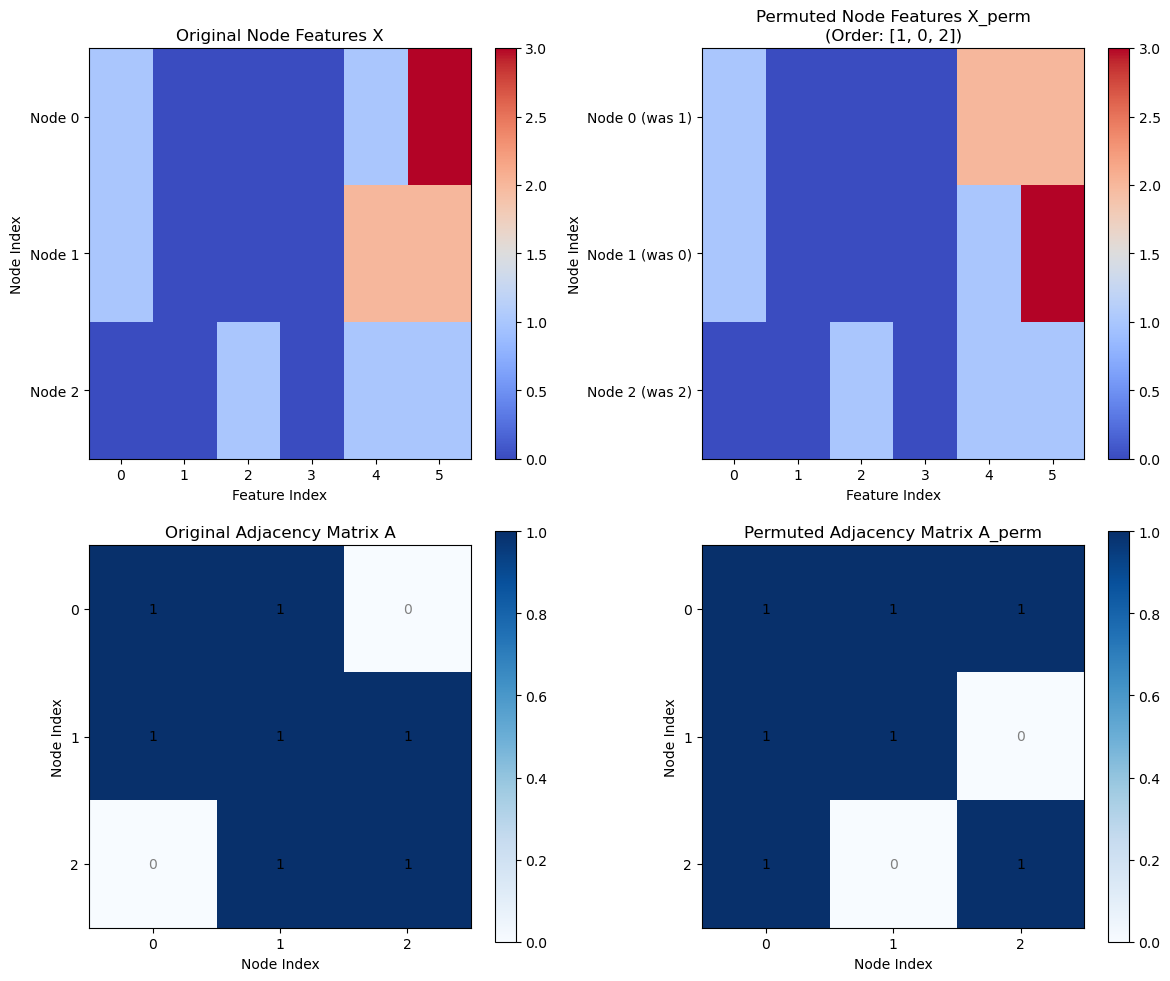

In [21]:
# 노드 특성과 인접 행렬의 시각적 비교
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 원본 노드 특성
im1 = axes[0, 0].imshow(X.numpy(), cmap='coolwarm', aspect='auto')
axes[0, 0].set_title('Original Node Features X')
axes[0, 0].set_xlabel('Feature Index')
axes[0, 0].set_ylabel('Node Index')
axes[0, 0].set_yticks(range(X.shape[0]))
axes[0, 0].set_yticklabels([f'Node {i}' for i in range(X.shape[0])])
plt.colorbar(im1, ax=axes[0, 0])

# Permuted 노드 특성
im2 = axes[0, 1].imshow(X_perm.numpy(), cmap='coolwarm', aspect='auto')
axes[0, 1].set_title(f'Permuted Node Features X_perm\n(Order: {perm_order})')
axes[0, 1].set_xlabel('Feature Index')
axes[0, 1].set_ylabel('Node Index')
axes[0, 1].set_yticks(range(X_perm.shape[0]))
axes[0, 1].set_yticklabels([f'Node {i} (was {perm_order[i]})' for i in range(X_perm.shape[0])])
plt.colorbar(im2, ax=axes[0, 1])

# 원본 인접 행렬
im3 = axes[1, 0].imshow(A.numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1, 0].set_title('Original Adjacency Matrix A')
axes[1, 0].set_xlabel('Node Index')
axes[1, 0].set_ylabel('Node Index')
axes[1, 0].set_xticks(range(A.shape[0]))
axes[1, 0].set_yticks(range(A.shape[0]))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        axes[1, 0].text(j, i, f'{A[i,j].item():.0f}', 
                       ha='center', va='center', color='black' if A[i,j] > 0.5 else 'gray')
plt.colorbar(im3, ax=axes[1, 0])

# Permuted 인접 행렬
im4 = axes[1, 1].imshow(A_perm.numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1, 1].set_title(f'Permuted Adjacency Matrix A_perm')
axes[1, 1].set_xlabel('Node Index')
axes[1, 1].set_ylabel('Node Index')
axes[1, 1].set_xticks(range(A_perm.shape[0]))
axes[1, 1].set_yticks(range(A_perm.shape[0]))
for i in range(A_perm.shape[0]):
    for j in range(A_perm.shape[1]):
        axes[1, 1].text(j, i, f'{A_perm[i,j].item():.0f}', 
                       ha='center', va='center', color='black' if A_perm[i,j] > 0.5 else 'gray')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

원본 그래프의 3-layer GCN 출력:
tensor([[ 0.0956,  0.0058,  0.1059,  0.0408, -0.0659, -0.0258, -0.0637,  0.0033],
        [ 0.1098,  0.0109,  0.1242,  0.0464, -0.0733, -0.0343, -0.0741,  0.0032],
        [ 0.0840,  0.0123,  0.0965,  0.0352, -0.0531, -0.0308, -0.0578,  0.0020]])

Permuted 그래프의 3-layer GCN 출력 (순서: [1, 0, 2]):
tensor([[ 0.1098,  0.0109,  0.1242,  0.0464, -0.0733, -0.0343, -0.0741,  0.0032],
        [ 0.0956,  0.0058,  0.1059,  0.0408, -0.0659, -0.0258, -0.0637,  0.0033],
        [ 0.0840,  0.0123,  0.0965,  0.0352, -0.0531, -0.0308, -0.0578,  0.0020]])

원본 출력을 permuted 순서로 재배열:
tensor([[ 0.1098,  0.0109,  0.1242,  0.0464, -0.0733, -0.0343, -0.0741,  0.0032],
        [ 0.0956,  0.0058,  0.1059,  0.0408, -0.0659, -0.0258, -0.0637,  0.0033],
        [ 0.0840,  0.0123,  0.0965,  0.0352, -0.0531, -0.0308, -0.0578,  0.0020]])

Permuted 그래프 출력:
tensor([[ 0.1098,  0.0109,  0.1242,  0.0464, -0.0733, -0.0343, -0.0741,  0.0032],
        [ 0.0956,  0.0058,  0.1059,  0.0408, -0.0659, -0.0258,

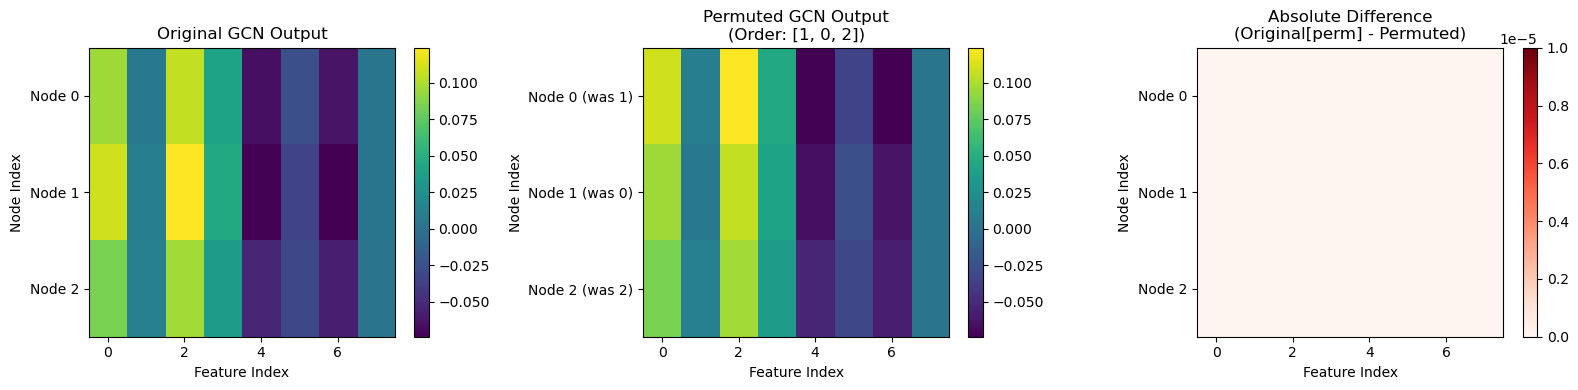

In [22]:
# 원본 그래프와 permuted 그래프를 모두 3-layer GCN에 통과
with torch.no_grad():
    _, out_original = model(X, A)
    _, out_perm = model(X_perm, A_perm)

print("원본 그래프의 3-layer GCN 출력:")
print(out_original)
print(f"\nPermuted 그래프의 3-layer GCN 출력 (순서: {perm_order}):")
print(out_perm)

# 원본의 permuted 순서와 permuted 그래프의 출력을 비교
print(f"\n원본 출력을 permuted 순서로 재배열:")
print(out_original[perm_indices])
print(f"\nPermuted 그래프 출력:")
print(out_perm)
print(f"\n두 출력이 같은가? {torch.allclose(out_original[perm_indices], out_perm, atol=1e-6)}")

# 시각적 비교
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 원본 GCN 출력
im1 = axes[0].imshow(out_original.numpy(), cmap='viridis', aspect='auto')
axes[0].set_title('Original GCN Output')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Node Index')
axes[0].set_yticks(range(out_original.shape[0]))
axes[0].set_yticklabels([f'Node {i}' for i in range(out_original.shape[0])])
plt.colorbar(im1, ax=axes[0])

# Permuted GCN 출력
im2 = axes[1].imshow(out_perm.numpy(), cmap='viridis', aspect='auto')
axes[1].set_title(f'Permuted GCN Output\n(Order: {perm_order})')
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Node Index')
axes[1].set_yticks(range(out_perm.shape[0]))
axes[1].set_yticklabels([f'Node {i} (was {perm_order[i]})' for i in range(out_perm.shape[0])])
plt.colorbar(im2, ax=axes[1])

# 차이 (should be zero after reordering)
diff = (out_original[perm_indices] - out_perm).abs().numpy()
im3 = axes[2].imshow(diff, cmap='Reds', aspect='auto', vmin=0, vmax=1e-5)
axes[2].set_title('Absolute Difference\n(Original[perm] - Permuted)')
axes[2].set_xlabel('Feature Index')
axes[2].set_ylabel('Node Index')
axes[2].set_yticks(range(diff.shape[0]))
axes[2].set_yticklabels([f'Node {i}' for i in range(diff.shape[0])])
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

### 핵심 관찰

위에서 볼 수 있듯이, **노드 순서를 바꾸면 각 노드의 embedding은 달라지지만**, 그것은 단순히 노드 인덱스가 바뀌었기 때문입니다. 

**중요한 점은**: permuted 그래프의 출력이 원본 그래프 출력을 같은 순서로 재배열한 것과 정확히 일치한다는 것입니다. 이것이 GCN의 **equivariance** 속성입니다.

이제 graph-level pooling을 적용하면 어떻게 되는지 확인해봅시다.

원본 그래프의 graph-level embedding (mean pooling):
tensor([ 0.0965,  0.0097,  0.1089,  0.0408, -0.0641, -0.0303, -0.0652,  0.0028])

Permuted 그래프의 graph-level embedding (mean pooling):
tensor([ 0.0965,  0.0097,  0.1089,  0.0408, -0.0641, -0.0303, -0.0652,  0.0028])

두 graph embedding이 같은가? True


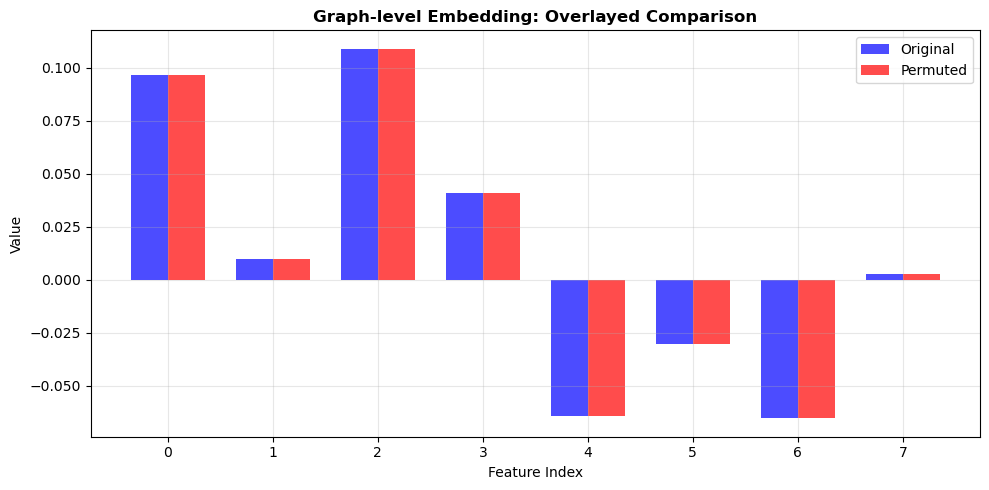

In [23]:
# Graph-level pooling 적용 (mean pooling)
graph_emb_original = out_original.mean(dim=0)
graph_emb_perm = out_perm.mean(dim=0)

print("원본 그래프의 graph-level embedding (mean pooling):")
print(graph_emb_original)
print(f"\nPermuted 그래프의 graph-level embedding (mean pooling):")
print(graph_emb_perm)
print(f"\n두 graph embedding이 같은가? {torch.allclose(graph_emb_original, graph_emb_perm, atol=1e-6)}")

# 시각화: 원본과 Permuted를 겹쳐서 비교
plt.figure(figsize=(10, 5))

x = range(len(graph_emb_original.tolist()))
width = 0.35
plt.bar([i - width/2 for i in x], graph_emb_original.tolist(), 
        width=width, color='blue', alpha=0.7, label='Original')
plt.bar([i + width/2 for i in x], graph_emb_perm.tolist(), 
        width=width, color='red', alpha=0.7, label='Permuted')
plt.title('Graph-level Embedding: Overlayed Comparison', fontsize=12, fontweight='bold')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 결론: Permutation Invariance

위 결과가 보여주는 것:

1. **Node-level equivariance**: GCN layer는 노드 순서를 바꾸면 출력도 같은 방식으로 바뀝니다. 즉, `GCN(X_perm, A_perm) = GCN(X, A)[perm]`

2. **Graph-level invariance**: Mean pooling과 같은 permutation-invariant 연산을 적용하면, 노드 순서와 관계없이 **동일한 graph embedding**을 얻습니다.

이것이 GNN이 그래프 데이터에 적합한 이유입니다. 그래프는 노드 순서가 정해져 있지 않지만, GNN은 이러한 순서에 관계없이 일관된 표현을 학습할 수 있습니다.

## 12. 전체 프로세스 요약

### GCN의 핵심 작동 원리

1. **분자 → 그래프 변환**
   - 원자 → 노드 (특성 벡터)
   - 결합 → 엣지 (인접 행렬)

2. **GCN Layer의 작동**
   - 인접 행렬을 정규화 (대칭 정규화)
   - 이웃 노드의 정보를 집계 (가중 평균)
   - 학습 가능한 가중치로 변환
   - 활성화 함수 적용

3. **다층 GCN**
   - 여러 layer를 쌓아 더 먼 이웃의 정보까지 통합
   - Layer가 깊어질수록 넓은 수용 범위 (receptive field)

4. **Graph Pooling**
   - 노드 임베딩을 하나의 그래프 벡터로 집계
   - Mean, Max, Sum 등 다양한 방법

5. **예측**
   - 그래프 임베딩을 MLP에 통과
   - 회귀/분류 문제 해결